In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import subprocess as sp
from scipy.stats.mstats import zscore

In [2]:
def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def get_background(counts, manifold, n_neighbors=100, remove_self=True):
    
    gene_list = counts.index
    
    n_genes = len(gene_list)
    n_cells = len(psi.index)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    if remove_self:
        distances = distances[:,1:]
        indices = indices[:,1:]

    sigma_array = np.max(distances, axis=1)
    
    weights = np.exp(-(distances**2)/(sigma_array**2).reshape(len(counts.columns),1))
    
    smooth_gene = pd.DataFrame()
    
    print('slicing exons...')
    pandas_slices = []
    for idx in indices:
        pandas_slices.append(counts.loc[gene_list].T.iloc[idx].to_numpy())

    pandas_slices = np.array(pandas_slices)

    for i in tqdm(range(len(gene_list)), position=0, leave=True):
        gene = gene_list[i]

        
        neighbors_gene = pandas_slices[:,:,i]
        

        background = np.nansum(neighbors_gene*weights, axis=1)/((~np.isnan(np.array(neighbors_gene)))*weights).sum(axis=1)


        smooth_gene[gene] = background

    smooth_gene.index = counts.columns
    
    return smooth_gene
    


# Neurogenesis modules

In [3]:
psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)

from sklearn.preprocessing import StandardScaler
# scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression.T).T)
# scaled_counts.index = norm_expression.index
# scaled_counts.columns = norm_expression.columns

In [4]:
clip_dir = '../rbp_binding/'
mouse_clip_overlap = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab.gz', sep='\t', index_col=0)
exon_length = pd.read_csv(clip_dir + 'exon_lengths.tab.gz', sep='\t', index_col=0, names=['ase', 'length'])

mouse_clip_overlap = mouse_clip_overlap.divide(exon_length.length, axis=0)

(2087, 12)


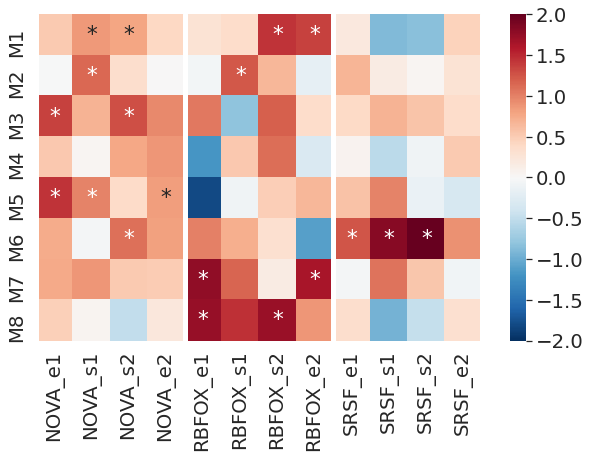

In [5]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [6]:
# mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

e1 = [x for x in mouse_clip_peaks.index if '_e1' in x]
e2 = [x for x in mouse_clip_peaks.index if '_e2' in x]
s1 = [x for x in mouse_clip_peaks.index if '_s1' in x]
s2 = [x for x in mouse_clip_peaks.index if '_s2' in x]
idx = [x[:-3] for x in mouse_clip_peaks.index if '_e1' in x]
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[e1]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[e2]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[s1]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[s2]

mouse_clip_peaks_e1.index = idx
mouse_clip_peaks_e2.index = idx
mouse_clip_peaks_s1.index = idx
mouse_clip_peaks_s2.index = idx

In [7]:
max_overlap= pd.concat([mouse_clip_peaks_e1, mouse_clip_peaks_s1, mouse_clip_peaks_s2, mouse_clip_peaks_e2]).max(level=0)

In [8]:
is_bound = mouse_clip_peaks_e1 + mouse_clip_peaks_e2 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2

In [9]:
binding_signatures = open('binding_signature.gmt', 'w')
signature = 'bound by {rbp}\tthere are overlapping clip tags'
for rbp in is_bound.columns:
    sig_rbp = signature.format(rbp=rbp)
    for exon in is_bound.index:
        if is_bound.loc[exon, rbp] > 0:
            sig_rbp += '\t' + exon
    sig_rbp  += '\n'
    binding_signatures.write(sig_rbp)
    
binding_signatures.close()

In [10]:
rnk = open('psix.rnk', 'w')
for idx, row in psix_results.iterrows():
    rnk.write(idx + '\t' + str(row.psix_score) + '\n')
    
rnk.close()

In [38]:
from numba import jit, njit

@njit
def enrichment_score(signal):
    
    Nr = 0
    for n in signal:
        if n < 0:
            Nr += -n
        else:
            Nr += n
#     Nr = np.sum(signal)
    
    suma = 0
    for s in signal:
        if s != 0:
            suma += 1
            
#     print(suma)
    
    missing = (len(signal) - suma)#np.sum(signal>0)
    denominator = missing
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        elif signal[i] < 0:
            current_p_hit += -signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    pdiff = []
    for i in range(len(p_hit)):
        pdiff.append(p_hit[i]-p_miss[i])
        
    return pdiff#p_hit-p_miss
    
def gsea(signal, bound, permutations=1000):
    
    signal_bound = list(np.array(signal) * np.array((bound>0).astype(int)))
    
    ES = np.max(enrichment_score(signal_bound))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_bound = np.random.choice(bound, len(signal), replace=False)
        
        random_signal = list(np.array(signal) * np.array((random_bound>0).astype(int)))
        
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

In [12]:
es_pvals_list = []
p_pvals_list = []

es_score_list = []
p_score_list = []

es_rank_list = []
p_rank_list = []

for rbp in is_bound.columns:
    es, p = gsea(-np.log10(psix_results.pvals), is_bound.loc[psix_results.index][rbp])
    es_pvals_list.append(es)
    p_pvals_list.append(p)
    
    es, p = gsea(psix_results.psix_score, is_bound.loc[psix_results.index][rbp])
    es_score_list.append(es)
    p_score_list.append(p)
    
    es, p = gsea(np.ones(2087), is_bound.loc[psix_results.index][rbp])
    es_rank_list.append(es)
    p_rank_list.append(p)
    
    
    
enrichment_pvals = pd.DataFrame()
enrichment_pvals['ES'] = es_pvals_list
enrichment_pvals['pvals'] = p_pvals_list
enrichment_pvals.index = is_bound.columns

enrichment_score = pd.DataFrame()
enrichment_score['ES'] = es_score_list
enrichment_score['pvals'] = p_score_list
enrichment_score.index = is_bound.columns

enrichment_rank = pd.DataFrame()
enrichment_rank['ES'] = es_rank_list
enrichment_rank['pvals'] = p_rank_list
enrichment_rank.index = is_bound.columns

/mnt/lareaulab/cfbuenabadn/.local/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'signal' of function 'enrichment_score'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-61f34d40862c>", line 4:
@njit
def enrichment_score(signal):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
100%|██████████| 1000/1000 [00:06<00:00, 150.78it/s]


In [13]:
bound_exons = is_bound.columns[is_bound.loc[psix_results.index].sum() > 0].sort_values()

enrichment_pvals = enrichment_pvals.loc[bound_exons]
enrichment_score = enrichment_score.loc[bound_exons]
enrichment_rank = enrichment_rank.loc[bound_exons]

""
enrichment_pvals['qvals'] = multipletests(enrichment_pvals['pvals'], method='fdr_bh')[1]
enrichment_score['qvals'] = multipletests(enrichment_score['pvals'], method='fdr_bh')[1]
enrichment_rank['qvals'] = multipletests(enrichment_rank['pvals'], method='fdr_bh')[1]

In [14]:
is_bound.columns[is_bound.loc[psix_results.index].sum() > 0].sort_values()

Index(['AGO2', 'CELF1', 'CELF4', 'CIRBP', 'ELAVL1', 'EZH2', 'FMR1', 'FUS',
       'LIN28A', 'MBNL1', 'MBNL1MBNL2', 'MBNL2', 'NOVA1', 'NOVA2', 'PABPC1',
       'PTBP1', 'RBFOX1', 'RBFOX2', 'RBFOX3', 'RBM3', 'SRRM4', 'SRSF1',
       'SRSF2', 'SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7', 'TAF15', 'TARDBP',
       'U2AF2', 'UPF1'],
      dtype='object')

In [15]:
enrichment_rank.loc[enrichment_rank.qvals <= 0.05].sort_index()

,ES,pvals,qvals
AGO2,0.209474,0.007992,0.015984
CELF4,0.369694,0.000999,0.002906
CIRBP,0.180966,0.000999,0.002906
EZH2,0.331669,0.018981,0.030370
FUS,0.155930,0.000999,0.002906
LIN28A,0.166437,0.000999,0.002906
MBNL1MBNL2,0.355449,0.004995,0.010656
MBNL2,0.443736,0.003996,0.009134
NOVA1,0.273697,0.000999,0.002906
NOVA2,0.378807,0.000999,0.002906


(2087, 48)


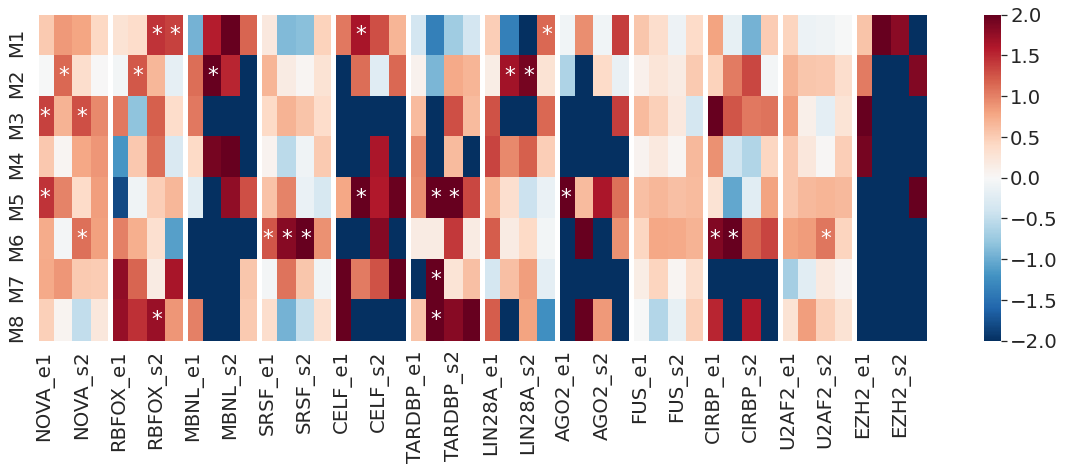

In [16]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))




mouse_clip_families['CELF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'CELF4'])
mouse_clip_families['CELF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'CELF4'])
mouse_clip_families['CELF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'CELF4'])
mouse_clip_families['CELF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'CELF4'])


mouse_clip_families['TARDBP_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'TARDBP'])
mouse_clip_families['TARDBP_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'TARDBP'])
mouse_clip_families['TARDBP_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'TARDBP'])
mouse_clip_families['TARDBP_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'TARDBP'])

mouse_clip_families['LIN28A_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'LIN28A'])
mouse_clip_families['LIN28A_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'LIN28A'])
mouse_clip_families['LIN28A_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'LIN28A'])
mouse_clip_families['LIN28A_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'LIN28A'])


mouse_clip_families['AGO2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'AGO2'])
mouse_clip_families['AGO2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'AGO2'])
mouse_clip_families['AGO2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'AGO2'])
mouse_clip_families['AGO2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'AGO2'])

mouse_clip_families['FUS_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'FUS'])
mouse_clip_families['FUS_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'FUS'])
mouse_clip_families['FUS_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'FUS'])
mouse_clip_families['FUS_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'FUS'])

mouse_clip_families['CIRBP_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'CIRBP'])
mouse_clip_families['CIRBP_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'CIRBP'])
mouse_clip_families['CIRBP_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'CIRBP'])
mouse_clip_families['CIRBP_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'CIRBP'])

mouse_clip_families['U2AF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'U2AF2'])
mouse_clip_families['U2AF2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'U2AF2'])
mouse_clip_families['U2AF2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'U2AF2'])
mouse_clip_families['U2AF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'U2AF2'])

mouse_clip_families['EZH2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'EZH2'])
mouse_clip_families['EZH2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'EZH2'])
mouse_clip_families['EZH2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'EZH2'])
mouse_clip_families['EZH2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'EZH2'])

mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        #enrichment = test_enrichment(mouse_clip_families.loc[modules.index][rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if (labels.loc[exon, rbp]) and (np.abs(hyper_enrichment.loc[exon, rbp]>=1)):
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [17]:
# modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
# binding_sites = pd.read_csv('~/Network/Mouse/SplicingNetwork/psix_events/motifs/cisbp_motifs/modules_centrimo/binding_sites.bed', 
#                             sep='\t', names = ['chrom', 'start', 'end', 'exon', 'ase', 'strand'])
# binding_sites.index = binding_sites.exon

# output_dir = '~/Network/Mouse/SplicingNetwork/psix_events/motifs/cisbp_motifs/modules_centrimo/bed/'
# run_fa = 'bedtools getfasta -s -fo {b}.fa -name '
# run_fa += '-fi /mnt/lareaulab/cfbuenabadn/Genomes/Mouse/mm10/GRCm38.primary_assembly.genome.fa -bed {b}.bed'

# for mod in range(1, 9):
#     mod_exons = modules.index[modules == mod]
    
#     for ext in ['_e1', '_e2', '_s1', '_s2']:
#         mod_exons_ext = [x + ext for x in mod_exons]
#         binding_sites.loc[mod_exons_ext].to_csv(output_dir + 'module_' + str(mod) + ext + '.bed', sep='\t',
#                                                index=False, header=False)
#         sp.run(run_fa.format(b=output_dir + 'module_' + str(mod) + ext), shell=True)



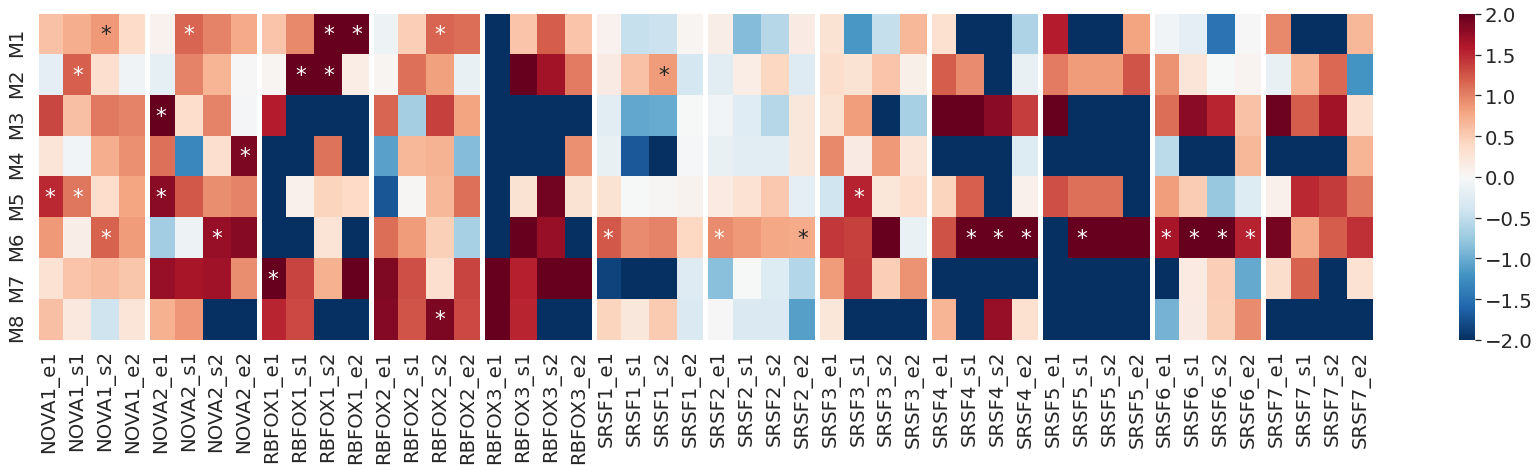

In [18]:
mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA1'])
mouse_clip_families['NOVA1_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'NOVA1'])
mouse_clip_families['NOVA1_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'NOVA1'])
mouse_clip_families['NOVA1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA1'])

mouse_clip_families['NOVA2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA2'])
mouse_clip_families['NOVA2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'NOVA2'])
mouse_clip_families['NOVA2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'NOVA2'])
mouse_clip_families['NOVA2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA2'])

mouse_clip_families['RBFOX1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX1'])

mouse_clip_families['RBFOX2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX2'])

mouse_clip_families['RBFOX3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX3'])

mouse_clip_families['SRSF1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF1'])
mouse_clip_families['SRSF1_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF1'])
mouse_clip_families['SRSF1_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF1'])
mouse_clip_families['SRSF1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF1'])

mouse_clip_families['SRSF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF2'])
mouse_clip_families['SRSF2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF2'])
mouse_clip_families['SRSF2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF2'])
mouse_clip_families['SRSF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF2'])

mouse_clip_families['SRSF3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF3'])
mouse_clip_families['SRSF3_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF3'])
mouse_clip_families['SRSF3_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF3'])
mouse_clip_families['SRSF3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF3'])

mouse_clip_families['SRSF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF4'])
mouse_clip_families['SRSF4_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF4'])
mouse_clip_families['SRSF4_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF4'])
mouse_clip_families['SRSF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF4'])

mouse_clip_families['SRSF5_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF5'])
mouse_clip_families['SRSF5_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF5'])
mouse_clip_families['SRSF5_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF5'])
mouse_clip_families['SRSF5_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF5'])

mouse_clip_families['SRSF6_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF6'])
mouse_clip_families['SRSF6_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF6'])
mouse_clip_families['SRSF6_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF6'])
mouse_clip_families['SRSF6_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF6'])

mouse_clip_families['SRSF7_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF7'])
mouse_clip_families['SRSF7_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'SRSF7'])
mouse_clip_families['SRSF7_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'SRSF7'])
mouse_clip_families['SRSF7_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF7'])

mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [19]:
modules_exons = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
modules_genes = pd.read_csv('psix_object/modules_genes.tab.gz', sep='\t', index_col=0).Module
modules_sf = pd.read_csv('psix_object/modules_sf.tab.gz', sep='\t', index_col=0).Module
splicing_factors = pd.read_csv('~/Network/Metadata/mouse_splicing_factors.txt', sep='\t', index_col=0).index

In [20]:
mod_sf = modules_genes.loc[splicing_factors & modules_genes.index]

In [21]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

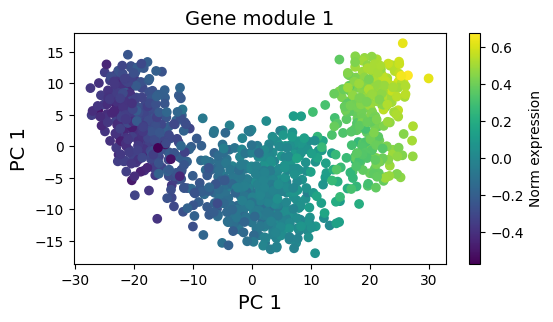

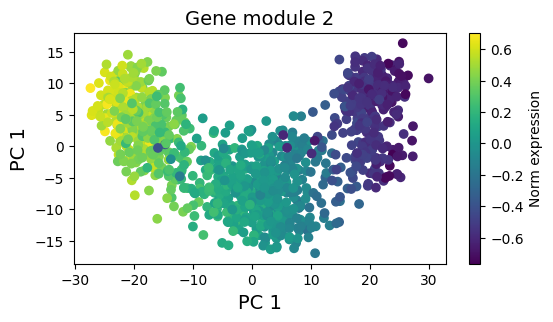

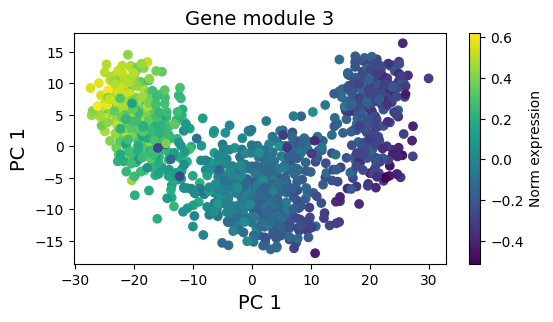

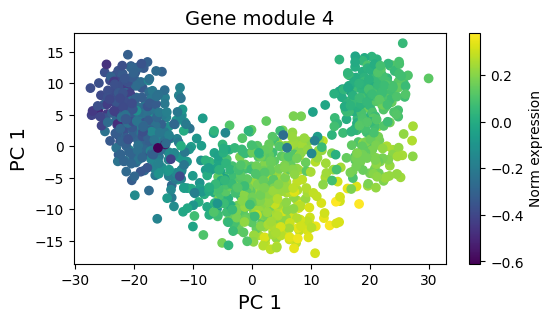

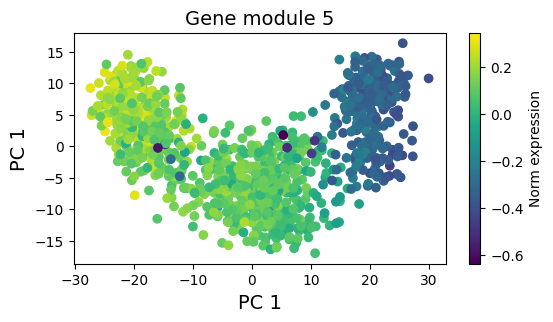

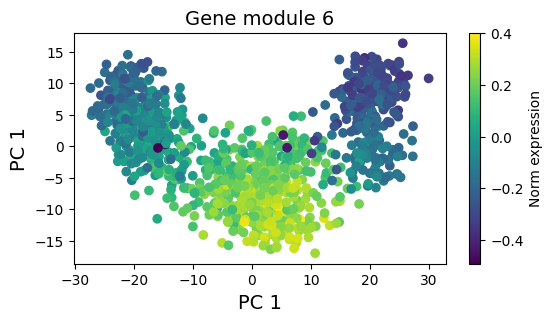

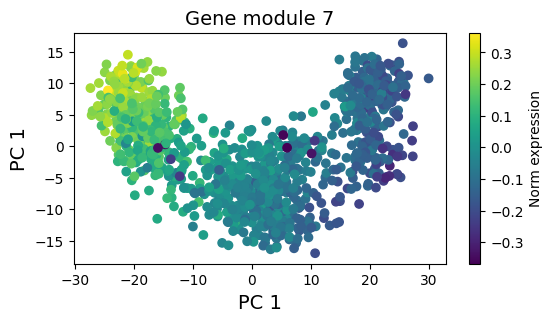

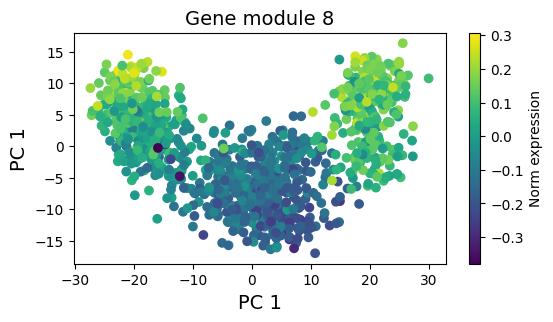

In [22]:
for mod in range(1, 9):
    plt.figure(figsize=(6, 3))
    sc = plt.scatter(latent.PC_1, latent.PC_2,
    c=zscore(norm_expression.loc[modules_genes.loc[modules_genes == mod].index, latent.index], axis=1).mean(axis=0),
           cmap='viridis')
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 1', fontsize=14)
    plt.title('Gene module ' + str(mod), fontsize=14)
    plt.colorbar(sc, label='Norm expression')
    plt.savefig('plots/gene_module_' + str(mod) + '.pdf', bbox_inches='tight')
    plt.show()

(2.0, 4.0)

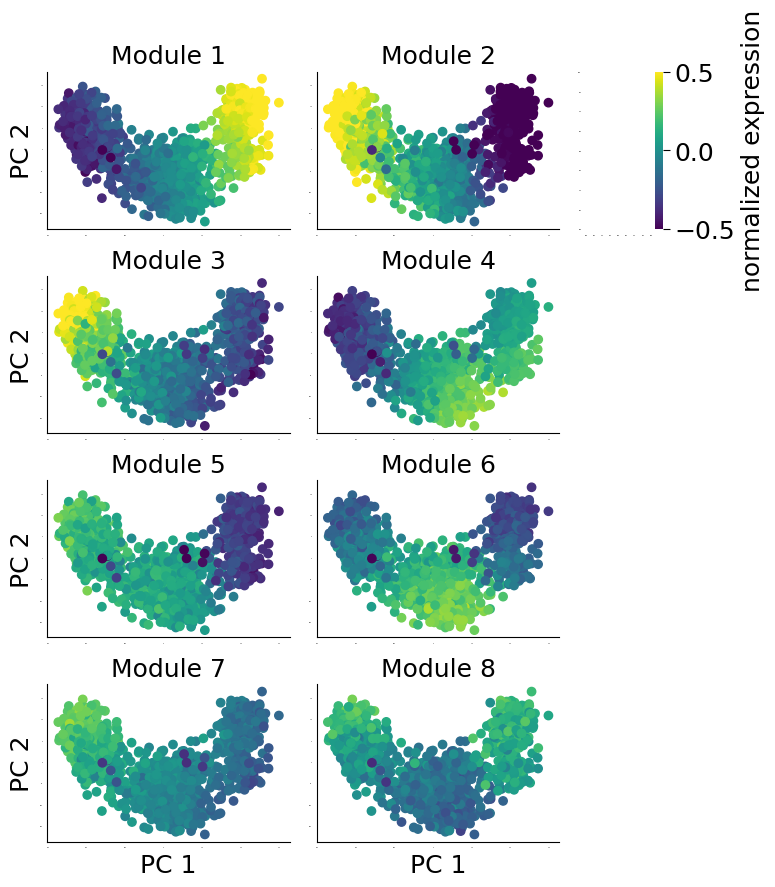

In [23]:
from scipy.stats import zscore
from itertools import product
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4,12)
gs.update(wspace=1, hspace=0.3)

ax_positions = list(product(range(4), range(2)))

for mod in range(1, 9):
    
    x, y = ax_positions[mod-1]
    
    ax = fig.add_subplot(gs[x,(5*y):(5*y)+5])

    sc = ax.scatter(latent.PC_1, 
                    latent.PC_2, 
                    c=zscore(norm_expression.loc[modules_genes.loc[modules_genes == mod].index, 
                                                 latent.index], axis=1).mean(axis=0), 
                    vmin=-0.5, vmax=0.5, cmap='viridis')
    
    
    plt.title('Module '+str(mod), fontsize=18)
    if x == 3:
        plt.xlabel('PC 1', fontsize=18)
    if y == 0:
        plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    ax.grid(False)
#     plt.show()
ax = fig.add_subplot(gs[0,10:12])
ax.grid(False)
sc = ax.scatter([0, 0], [0, 0], c=[-0.5, 0.5])
cb = plt.colorbar(sc, shrink = 1, aspect=20)
cb.set_label(label='normalized expression',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(labelsize=0, length=0)
ax.set_xlim((2, 4))
ax.set_ylim((2, 4))

(2.0, 4.0)

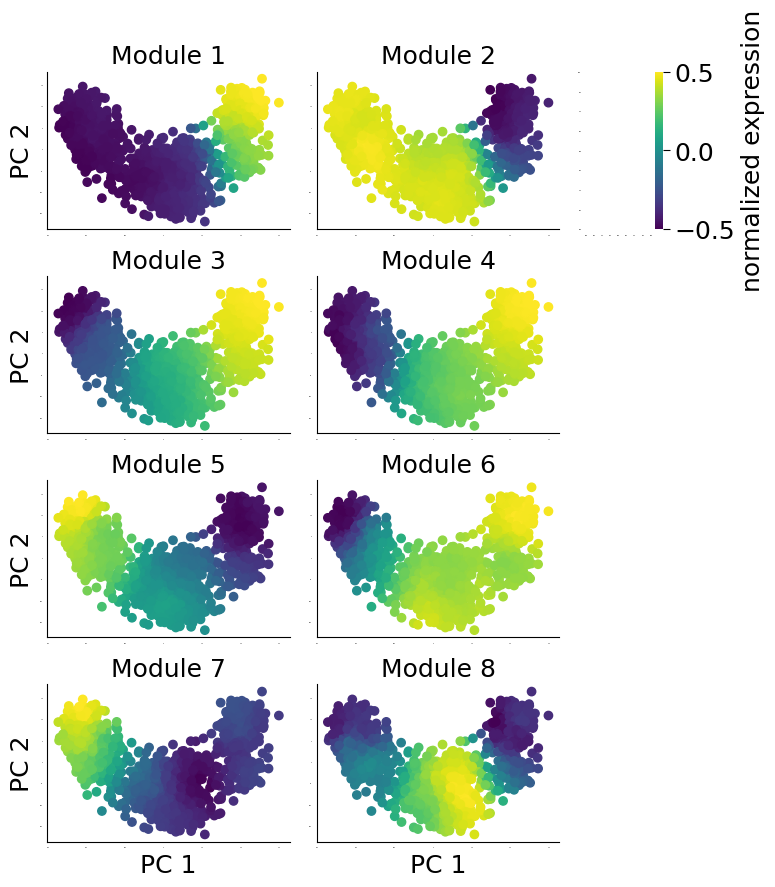

In [24]:
from scipy.stats import zscore
from itertools import product
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4,12)
gs.update(wspace=1, hspace=0.3)

ax_positions = list(product(range(4), range(2)))

for mod in range(1, 9):
    
    x, y = ax_positions[mod-1]
    
    ax = fig.add_subplot(gs[x,(5*y):(5*y)+5])

    sc = ax.scatter(latent.PC_1, 
                    latent.PC_2, 
                    c=np.nanmean(zscore(neighbors_psi.loc[modules_exons.index[modules_exons == mod]], axis=1, 
                                             nan_policy='omit'), axis=0), cmap='viridis')
    
    
    plt.title('Module '+str(mod), fontsize=18)
    if x == 3:
        plt.xlabel('PC 1', fontsize=18)
    if y == 0:
        plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    ax.grid(False)
#     plt.show()
ax = fig.add_subplot(gs[0,10:12])
ax.grid(False)
sc = ax.scatter([0, 0], [0, 0], c=[-0.5, 0.5])
cb = plt.colorbar(sc, shrink = 1, aspect=20)
cb.set_label(label='normalized expression',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(labelsize=0, length=0)
ax.set_xlim((2, 4))
ax.set_ylim((2, 4))

In [25]:
from numba import jit

def compute_cell_metric_light(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(manifold.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric

# @jit(nopython=True)
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 

# @jit(nopython=True)
def get_exon_neighbors_psi(observed_psi_array, cell_metric):
    psi_a_array = []
    for i in range(len(observed_psi_array)):
#         psi_o = observed_psi_array[i]
                    
#         psi_o_array.append(psi_o)

        neighbors = cell_metric[0][i]
        weights = cell_metric[1][i]

        psi_sum = 0
        weight_sum = 0
        for j in range(len(neighbors)):
            psi_n = observed_psi_array[neighbors[j]]
            if not np.isnan(psi_n):
                psi_sum += (psi_n * weights[j])
                weight_sum += weights[j]
        if weight_sum > 0:
            psi_a_array.append(psi_sum/weight_sum)
        else:
            psi_a_array.append(np.nan)
                
    return psi_a_array


def get_all_exons_neighbors(psi, cell_metric):
    
    neighbors_psi = []
    
    for exon_psi in tqdm(psi.T, position=0, leave=True):
        neighbors_psi.append(get_exon_neighbors_psi(exon_psi, cell_metric))
        
    return np.array(neighbors_psi)


In [26]:
cell_metric = compute_cell_metric_light(latent)

100%|██████████| 1067/1067 [00:00<00:00, 1777.14it/s]


In [27]:
sf_neighbors = get_all_exons_neighbors(
    np.array(norm_expression.loc[splicing_factors & norm_expression.index, latent.index].T),
    cell_metric
)

100%|██████████| 221/221 [01:41<00:00,  2.17it/s]


In [28]:
sf_neighbors = pd.DataFrame(sf_neighbors, index=splicing_factors & norm_expression.index,
                                 columns=latent.index)
sf_neighbors = sf_neighbors.T

In [29]:
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)


In [30]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize=(6, 3))
sc = plt.scatter(latent.PC_1, latent.PC_2,
c=sf_neighbors.loc['Rbfox1'],
       cmap='viridis')
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 1', fontsize=14)
plt.title('Rbfox1', fontsize=14)
plt.colorbar(sc, label='Norm expression')
# plt.savefig('plots/gene_module_' + str(mod) + '.pdf', bbox_inches='tight')
plt.show()

KeyError: 'Rbfox1'

<Figure size 600x300 with 0 Axes>

In [45]:
from scipy.stats import pearsonr, spearmanr
sf_neighbors = sf_neighbors.drop_duplicates()
corr = pd.DataFrame()
for rbp in tqdm(sf_neighbors.index, leave=True, position=0):
    rbp_corr_list = []
    for exon in modules.index:
        m = neighbors_psi.loc[exon].mean()
        r, p = pearsonr(sf_neighbors.loc[rbp], neighbors_psi.loc[exon].fillna(m))
        rbp_corr_list.append(r)
    corr[rbp] = rbp_corr_list
    
corr.index = modules.index

100%|██████████| 217/217 [02:30<00:00,  1.45it/s]


In [46]:
modules

Mapt_1       1
Dbn1_1       1
Ndrg4_1      1
Mapt_3       1
Gabrg2_1     1
            ..
Rsrc1_7      8
Iffo1_1      8
Dram2_6      6
Smarce1_9    7
Sorbs2_9    -1
Name: Module, Length: 818, dtype: int64

In [47]:
corr = corr[modules_genes.index & sf_neighbors.index]

In [48]:
exon_order = list(modules.loc[modules==-1].index & corr.index)

for i in [3, 4, 6, 1, 7, 5, 2, 8]:
    exon_order.extend(list(modules.loc[modules==i].index & corr.index))
    
    
gene_order = []

for i in [1, 4, 8, 6, 7, 5, 3, 2]:
    gene_order.extend(list(modules_genes.loc[modules_genes==i].index & corr.columns))
    
# gene_order = modules_genes.sort_values().index & corr.columns

corr = corr.loc[exon_order, gene_order]

exon_mod_colors = []
for exon in corr.index:
    if modules_exons.loc[exon] == 1:
        exon_mod_colors.append('tab:blue')
    elif modules_exons.loc[exon] == 2:
        exon_mod_colors.append('tab:green')
    elif modules_exons.loc[exon] == 3:
        exon_mod_colors.append('tab:red')
    elif modules_exons.loc[exon] == 4:
        exon_mod_colors.append('tab:purple')
    elif modules_exons.loc[exon] == 5:
        exon_mod_colors.append('tab:brown')
    elif modules_exons.loc[exon] == 6:
        exon_mod_colors.append('tab:pink')
    elif modules_exons.loc[exon] == 7:
        exon_mod_colors.append('tab:gray')
    elif modules_exons.loc[exon] == 8:
        exon_mod_colors.append('tab:cyan')
    else:
        exon_mod_colors.append('white')
        
        
gene_mod_colors = []
for gene in corr.columns:
    if modules_genes.loc[gene] == 1:
        gene_mod_colors.append('tab:blue')
    elif modules_genes.loc[gene] == 2:
        gene_mod_colors.append('tab:green')
    elif modules_genes.loc[gene] == 3:
        gene_mod_colors.append('tab:red')
    elif modules_genes.loc[gene] == 4:
        gene_mod_colors.append('tab:purple')
    elif modules_genes.loc[gene] == 5:
        gene_mod_colors.append('tab:brown')
    elif modules_genes.loc[gene] == 6:
        gene_mod_colors.append('tab:pink')
    elif modules_genes.loc[gene] == 7:
        gene_mod_colors.append('tab:gray')
    elif modules_genes.loc[gene] == 8:
        gene_mod_colors.append('tab:cyan')
    else:
        gene_mod_colors.append('white')

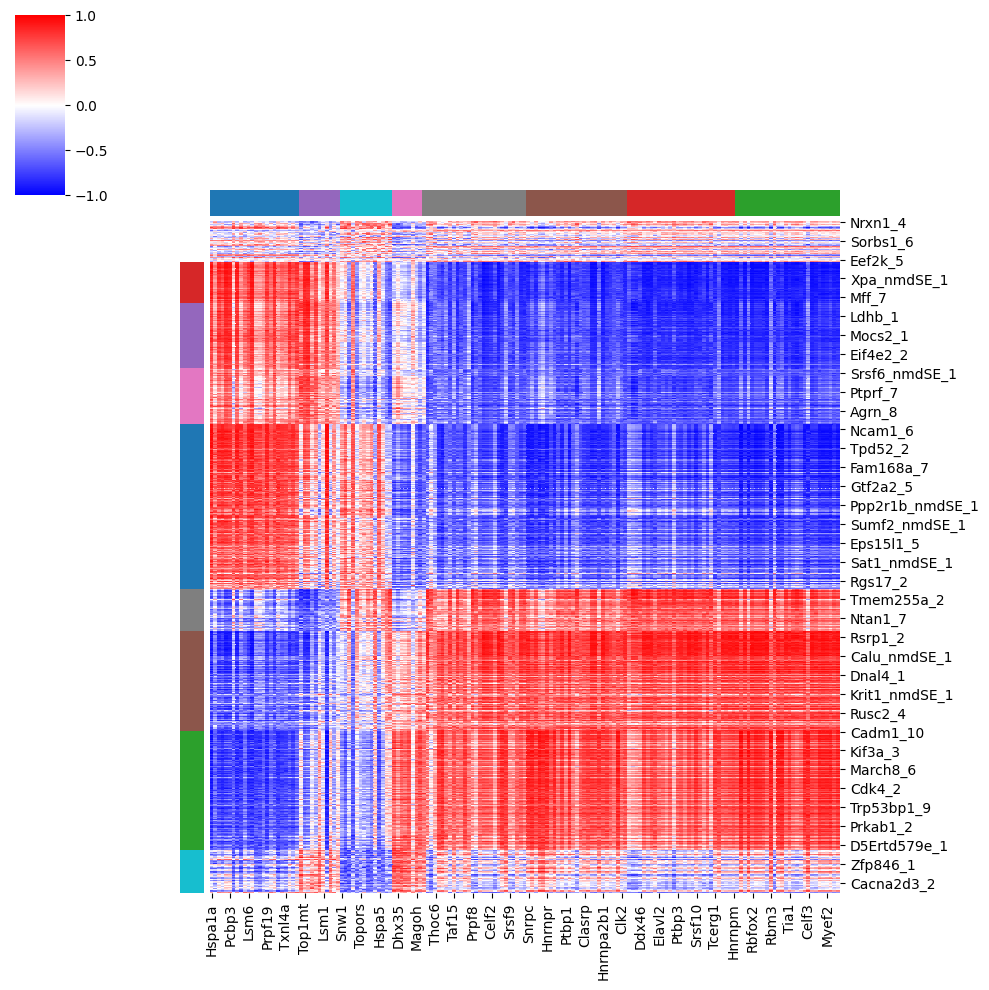

In [49]:
sns.clustermap(corr, cmap='bwr', vmin=-1, vmax=1, col_colors=gene_mod_colors, row_colors=exon_mod_colors,
              col_cluster=False, row_cluster=False)
plt.show()

In [63]:
module_avg = pd.DataFrame()

for mod in range(1, 9):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules_exons.index[modules_exons == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
                               index = sf_neighbors.index, columns = module_avg.index)
for sf in tqdm(sf_neighbors.index):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]

In [116]:
module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
                               index = sf_neighbors.index, columns = module_avg.index)
for sf in tqdm(sf_neighbors.index):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]

100%|██████████| 217/217 [00:02<00:00, 80.32it/s]


In [117]:
sig_sf = pd.Index(['Ago2',
 'Celf4',
 'Cirbp',
 'Ezh2',
 'Fus',
 'Lin28a',
 'Mbnl1',
 'Mbnl2',
 'Nova1',
 'Nova2',
 'Rbfox1',
 'Rbfox2',
 'Rbfox3',
 'Srsf3',
 'Srsf4',
 'Srsf5',
 'Srsf6',
 'Srsf7',
 'Tardbp',
 'U2af2']) & module_avg_corr.index

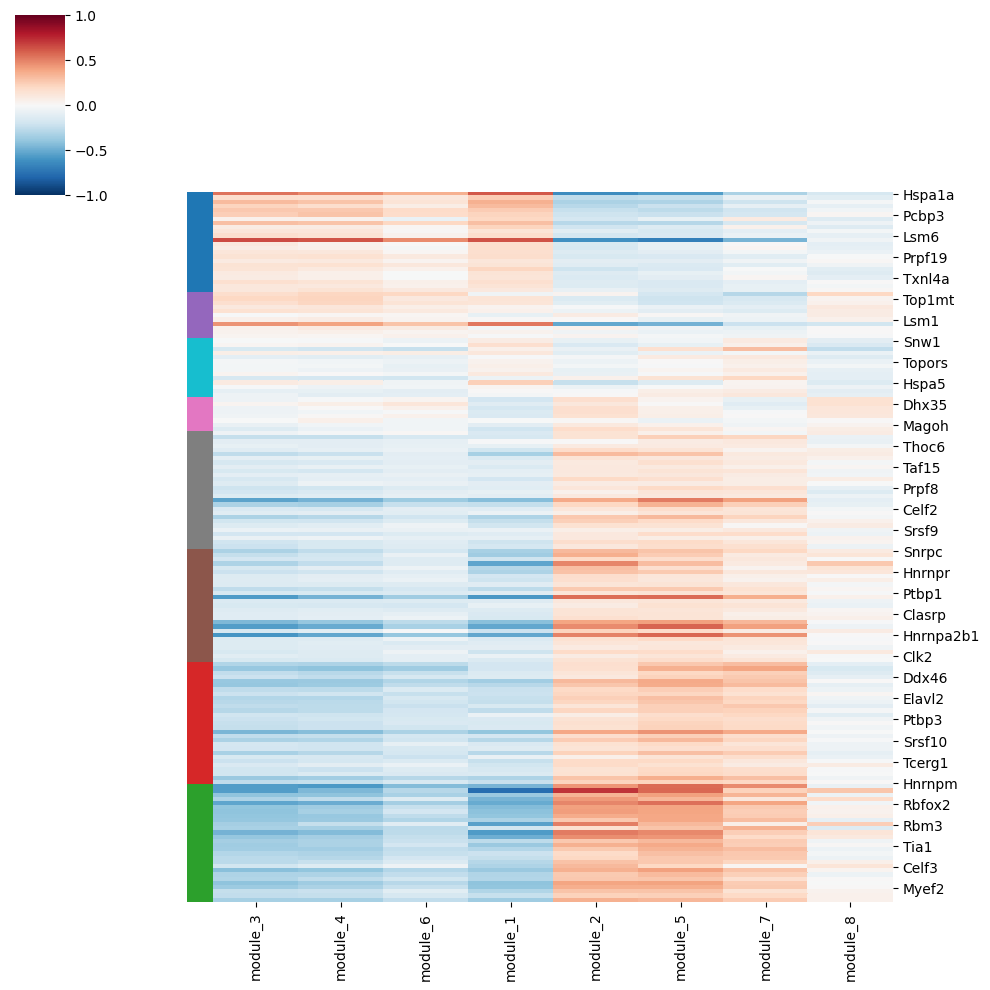

In [118]:
mod_order = ['module_3', 'module_4', 'module_6', 'module_1',
             'module_2', 'module_5', 'module_7', 'module_8']
sns.clustermap(module_avg_corr.loc[gene_order, mod_order], col_cluster=False,
              row_colors = gene_mod_colors, row_cluster=False, vmin=-1, vmax=1, cmap='RdBu_r')

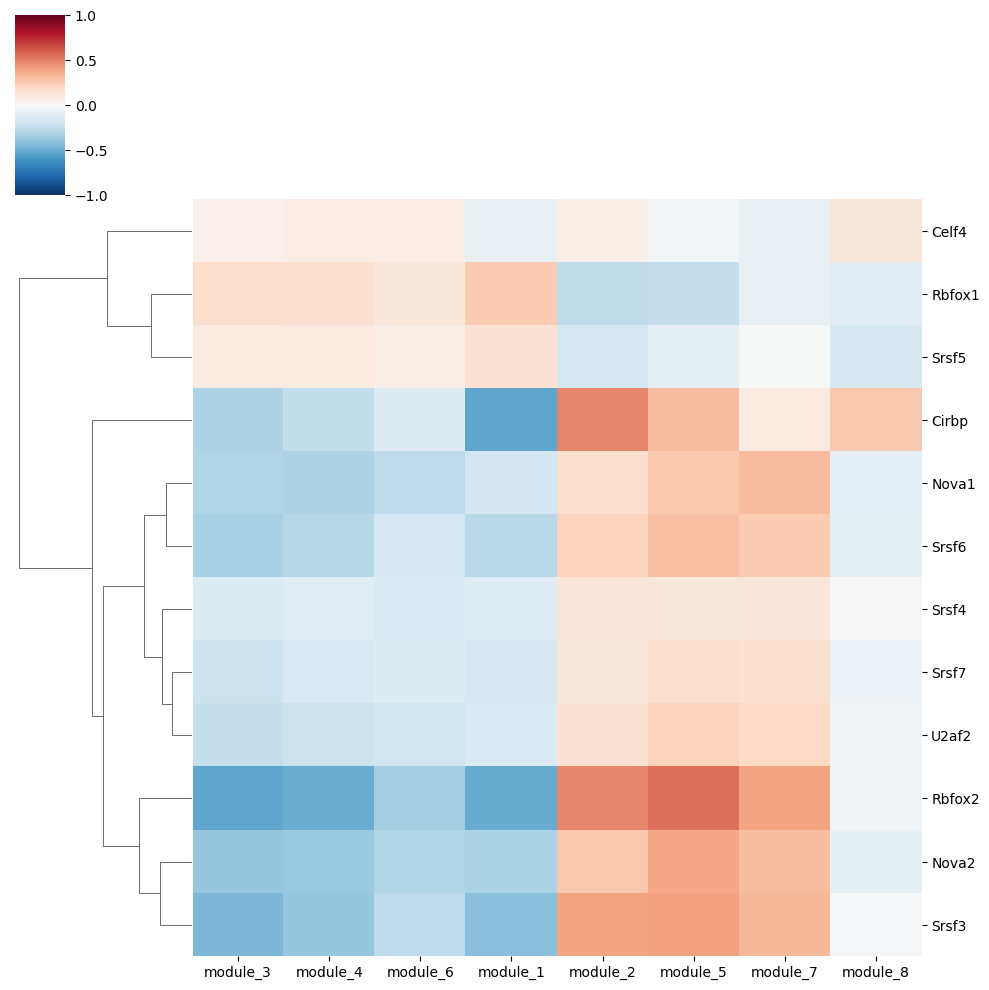

In [119]:
mod_order = ['module_3', 'module_4', 'module_6', 'module_1',
             'module_2', 'module_5', 'module_7', 'module_8']
sns.clustermap(module_avg_corr.loc[sig_sf, mod_order], 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-1, vmax=1, cmap='RdBu_r')

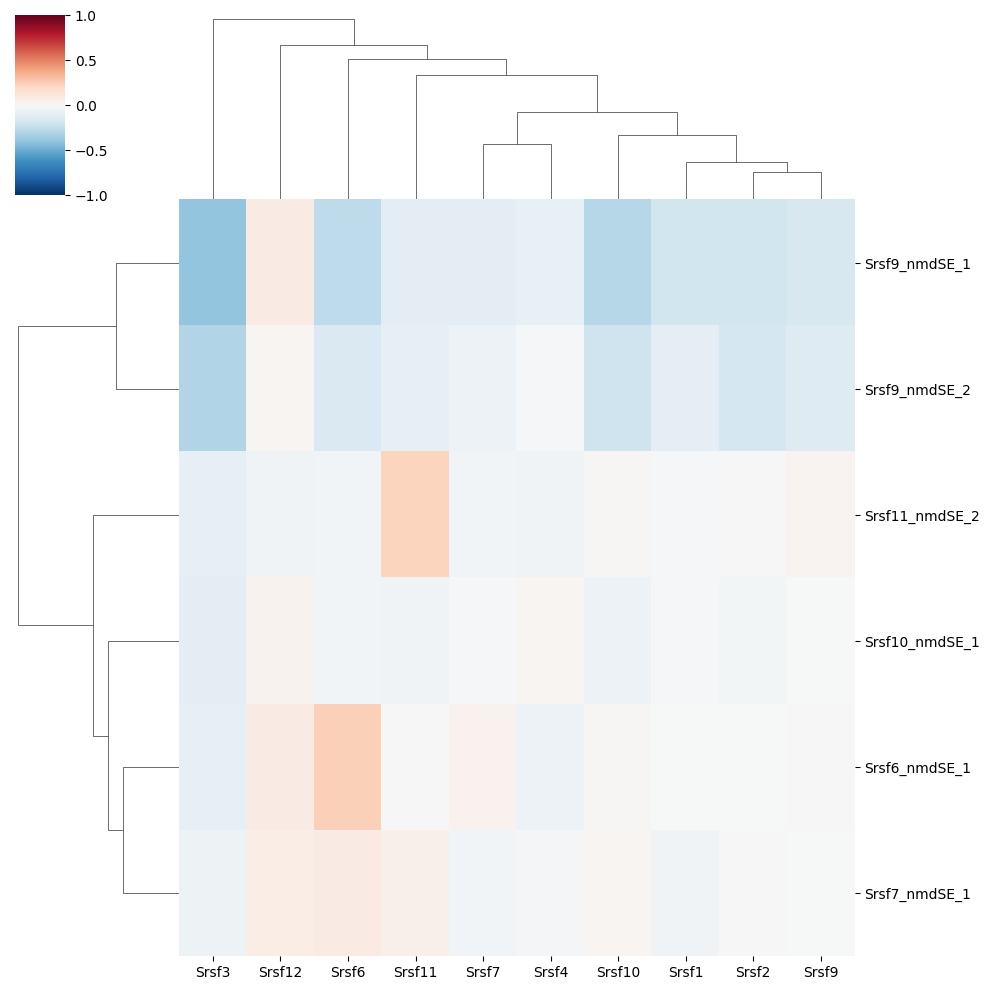

In [130]:
sr_modules_corr = pd.DataFrame(np.zeros((len([x for x in modules_exons.index if (('Srsf' in x) and ('nmdSE' in x))]),
                                        len([x for x in gene_order if 'Srsf' in x]))),
                              index = [x for x in modules_exons.index if (('Srsf' in x) and ('nmdSE' in x))],
                              columns = [x for x in gene_order if 'Srsf' in x])

for sr in [x for x in modules_exons.index if (('Srsf' in x) and ('nmdSE' in x))]:
    for sr_p in [x for x in gene_order if 'Srsf' in x]:
        
        not_nan = psi.loc[sr].dropna().index
        
        sr_modules_corr.loc[sr, sr_p] = spearmanr(psi.loc[sr, not_nan],
                                                norm_expression.loc[sr_p, not_nan])[0]
        

sns.clustermap(sr_modules_corr, vmax=1, vmin=-1, cmap='RdBu_r')

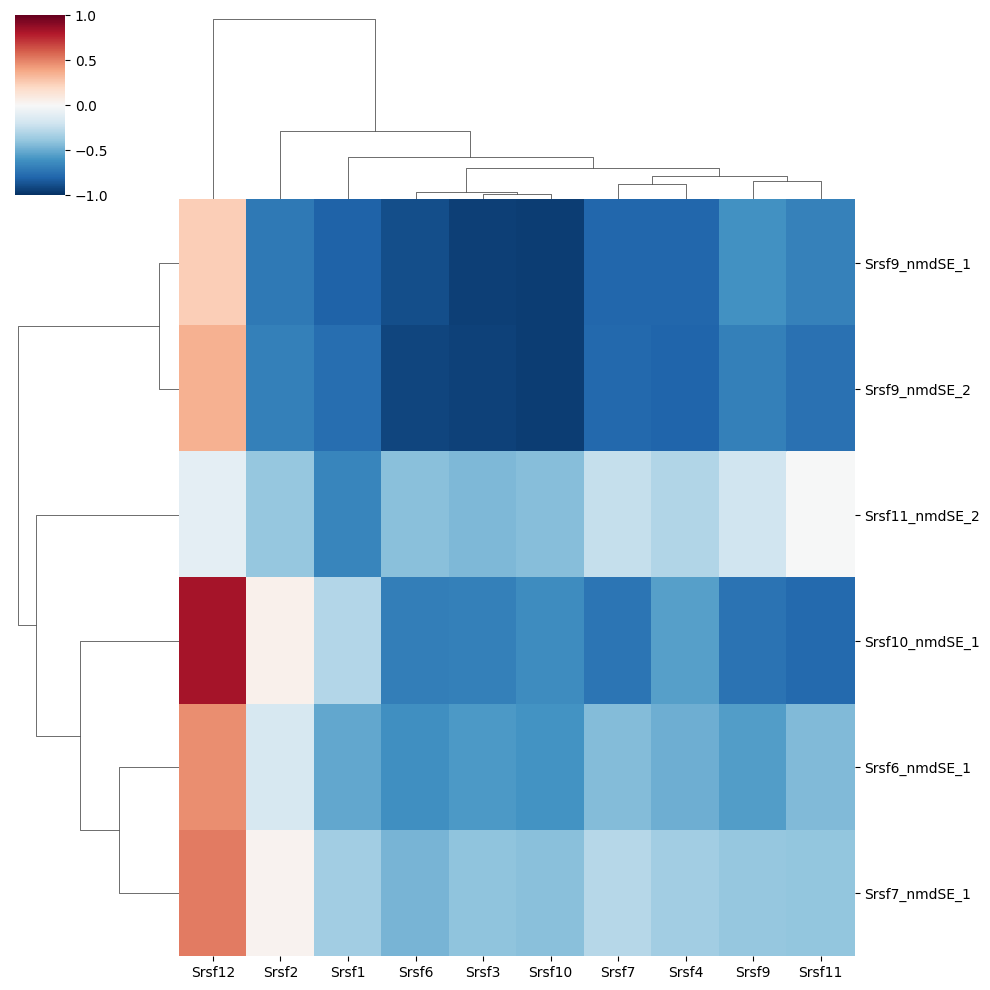

In [147]:
sns.clustermap(corr.loc[[x for x in modules_exons.index if (('Srsf' in x) and ('nmdSE' in x))],
                        [x for x in gene_order if 'Srsf' in x]], vmax=1, vmin=-1, cmap='RdBu_r')

Text(0.5, 1.0, 'Srsf6 poison exon')

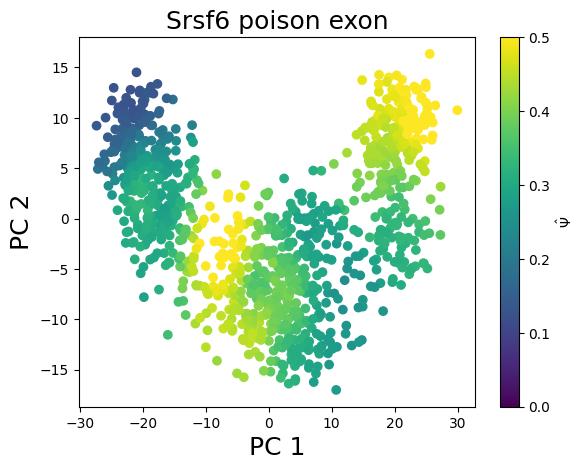

In [158]:
sc = plt.scatter(latent.PC_1, latent.PC_2, c=neighbors_psi.loc['Srsf6_nmdSE_1', psi.columns], vmin=0, vmax=0.5)
plt.colorbar(sc, label='$\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Srsf6 poison exon', fontsize=18)

Text(0.5, 1.0, 'Srsf6 expression')

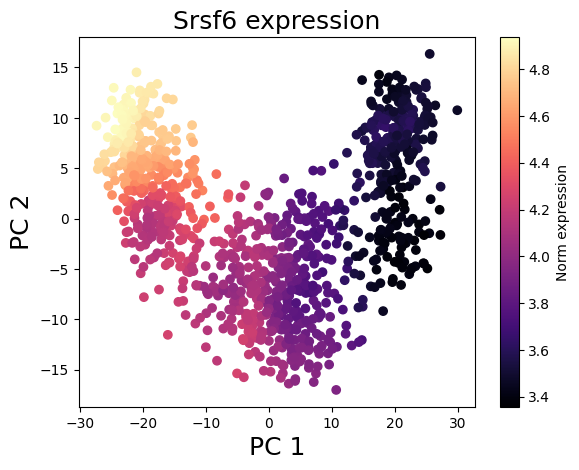

In [155]:
sc = plt.scatter(latent.PC_1, latent.PC_2, c=sf_neighbors.loc['Srsf6', psi.columns], cmap='magma')
plt.colorbar(sc, label='Norm expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Srsf6 expression', fontsize=18)

In [150]:
not_nan = psi.loc['Srsf6_nmdSE_1', psi.columns].dropna().index
final_sr = [x for x in not_nan if norm_expression.loc['Srsf6', x]>4]

In [152]:
pearsonr(norm_expression.loc['Srsf6', final_sr], psi.loc['Srsf6_nmdSE_1', final_sr])

(0.0719683183752482, 0.05975558204564143)

In [31]:
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

In [160]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/SE_counts_filtered.tab.gz',
        'data/preprocess/tables/constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/rsem_gene_tpm_filtered.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:45<00:00, 23.26it/s]


Successfully processed RNA-seq data


In [161]:
psix_object.adata.uns['mrna_per_event']

,Aamdc_9,Aamdc_10,Aasdhppt_2,Abat_3,Abca3_4,Abhd10_1,Abhd10_2,Abhd14a_1,Abhd14a_3,Abi1_8,...,Zmym3_7,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,l7Rn6_1,l7Rn6_3,l7Rn6_nmdSE_1
SRR7408400,0.917450,3.669801,NaN,NaN,NaN,NaN,NaN,6.422152,4.587251,3.669801,...,0.917450,2.752351,NaN,NaN,NaN,NaN,NaN,1.834901,1.834901,2.752351
SRR7408401,NaN,NaN,4.176126,NaN,NaN,2.088063,3.654110,NaN,NaN,NaN,...,NaN,NaN,3.132094,NaN,NaN,NaN,0.522016,7.830236,3.132094,NaN
SRR7408404,NaN,1.618193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809096,...,3.236386,NaN,NaN,2.831838,4.045482,NaN,NaN,1.618193,NaN,3.236386
SRR7408413,NaN,NaN,1.144291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.288582,NaN,NaN,0.572145,NaN,1.144291
SRR7408414,NaN,NaN,NaN,NaN,0.963137,4.494638,1.926274,NaN,NaN,2.568365,...,NaN,3.210456,0.642091,1.284182,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,3.330434,2.960386,4.810627,11.471496,NaN,9.621255,4.440579,6.660869,4.810627,2.590338,...,9.251207,2.590338,3.700483,NaN,12.581641,0.370048,0.740097,NaN,NaN,NaN
SRR7410093,1.302721,5.862243,7.164964,0.651360,1.302721,NaN,NaN,NaN,NaN,NaN,...,1.954081,NaN,NaN,NaN,NaN,4.559522,1.302721,0.651360,0.651360,1.302721
SRR7410094,1.179902,2.359805,0.786602,0.393301,NaN,NaN,0.393301,0.786602,0.786602,3.146406,...,7.079414,2.359805,NaN,NaN,4.719610,0.393301,NaN,1.966504,1.573203,2.359805
SRR7410096,9.670676,13.700125,0.805890,4.029448,0.805890,1.611779,3.223559,1.611779,1.611779,0.805890,...,2.417669,1.611779,NaN,NaN,3.223559,1.611779,NaN,2.417669,4.835338,NaN


In [ ]:
module_avg_genes = pd.DataFrame()

for mod in range(1, 9):
    module_avg_genes['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules_genes.index[modules_genes == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg_genes.index = psi.columns
module_avg_genes = module_avg_genes.T

In [10]:
from scipy.stats import pearsonr, spearmanr

In [11]:
splicing_factors = splicing_factors & norm_expression.index

In [52]:
sf_correlation = pd.DataFrame(np.zeros((len(splicing_factors), len(module_average.index))), 
                             index = splicing_factors, columns = module_average.index)

In [53]:
for sf in tqdm(splicing_factors, position=0, leave=True):
    for mod in module_average.index:
        sf_correlation.loc[sf, mod] = spearmanr(module_average.loc[mod], 
                                               norm_expression.loc[sf, module_average.columns])[0]

100%|██████████| 221/221 [00:04<00:00, 53.95it/s]


In [54]:
order = (sf_correlation.Mod_7 - sf_correlation.Mod_1).sort_values().index

In [55]:
from scipy.cluster.hierarchy import linkage

# P90 modules

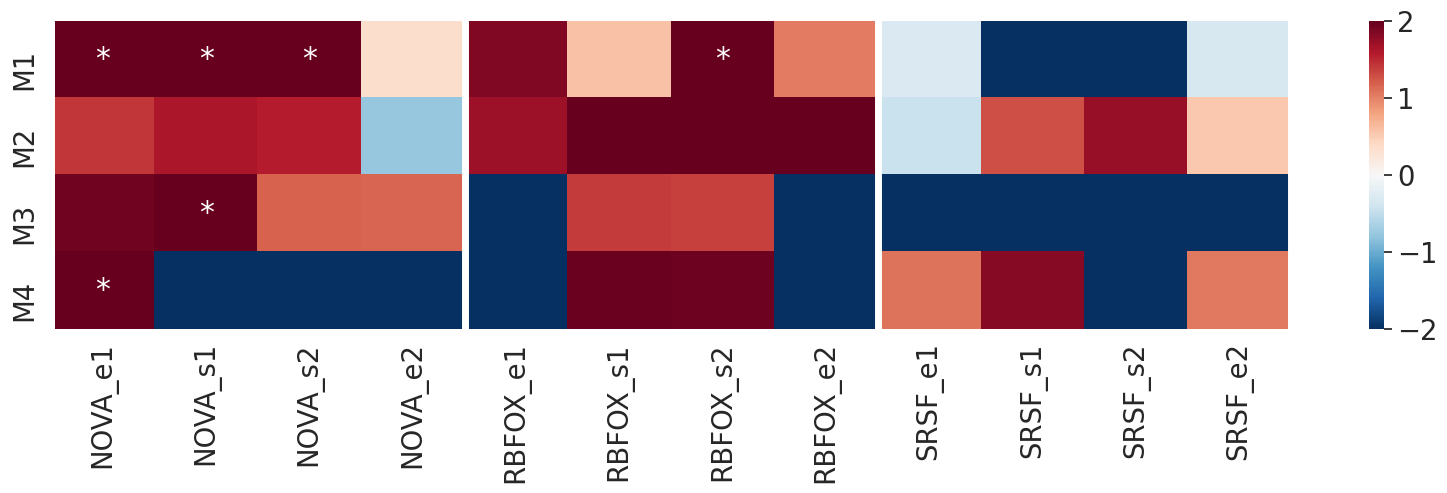

In [32]:
psix_results_p90 = pd.read_csv('psix_object_p90/psix_results.tab.gz', sep='\t', index_col=0)

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]



# mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results_p90.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 4))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [35]:
psix_results_p90

,psix_score,pvals,qvals
Nrxn1_4,0.534807,0.000500,0.013727
Aplp2_3,0.510770,0.000500,0.013727
Stxbp1_2,0.488766,0.000500,0.013727
Cadps_7,0.463514,0.000500,0.013727
Bnip2_nmdSE_1,0.428936,0.000500,0.013727
...,...,...,...
Zfp688_nmdSE_1,-0.265449,0.977011,0.992074
Nasp_5,-0.269500,0.991504,0.995741
Brsk2_10,-0.278889,0.982509,0.992074
Srsf11_nmdSE_4,-0.291752,0.995502,0.997389


In [39]:
es_pvals_list = []
p_pvals_list = []

es_score_list = []
p_score_list = []

es_rank_list = []
p_rank_list = []

for rbp in is_bound.columns:
    es, p = gsea(-np.log10(psix_results_p90.pvals), is_bound.loc[psix_results_p90.index][rbp])
    es_pvals_list.append(es)
    p_pvals_list.append(p)
    
    es, p = gsea(psix_results_p90.psix_score, is_bound.loc[psix_results_p90.index][rbp])
    es_score_list.append(es)
    p_score_list.append(p)
    
    es, p = gsea(np.ones(2115), is_bound.loc[psix_results_p90.index][rbp])
    es_rank_list.append(es)
    p_rank_list.append(p)
    
    
    
enrichment_pvals = pd.DataFrame()
enrichment_pvals['ES'] = es_pvals_list
enrichment_pvals['pvals'] = p_pvals_list
enrichment_pvals.index = is_bound.columns

enrichment_score = pd.DataFrame()
enrichment_score['ES'] = es_score_list
enrichment_score['pvals'] = p_score_list
enrichment_score.index = is_bound.columns

enrichment_rank = pd.DataFrame()
enrichment_rank['ES'] = es_rank_list
enrichment_rank['pvals'] = p_rank_list
enrichment_rank.index = is_bound.columns

100%|██████████| 1000/1000 [00:07<00:00, 140.26it/s]


In [41]:
# enrichment_pvals = enrichment_pvals.loc[bound_exons]
# enrichment_score = enrichment_score.loc[bound_exons]
# enrichment_rank = enrichment_rank.loc[bound_exons]

# ""
enrichment_pvals['qvals'] = multipletests(enrichment_pvals['pvals'], method='fdr_bh')[1]
enrichment_score['qvals'] = multipletests(enrichment_score['pvals'], method='fdr_bh')[1]
enrichment_rank['qvals'] = multipletests(enrichment_rank['pvals'], method='fdr_bh')[1]

In [42]:
enrichment_pvals.loc[enrichment_pvals.qvals <= 0.05]

,ES,pvals,qvals
RBFOX3,0.630184,0.005994,0.038362
NOVA2,0.596182,0.000999,0.015984
MBNL2,0.745708,0.002997,0.031968
NOVA1,0.520201,0.000999,0.015984
RBFOX1,0.597474,0.005994,0.038362


In [43]:
neighbors_psi_p90 = pd.read_csv('data/preprocess/tables/neighbors_psi_p90.tab.gz', sep='\t', index_col=0)
psi_p90 = pd.read_csv('data/preprocess/tables/psi_p90.tab.gz', sep='\t', index_col=0)
latent_p90 = pd.read_csv('data/preprocess/tables/p90_pc2_rd.tab.gz', sep='\t', index_col=0)


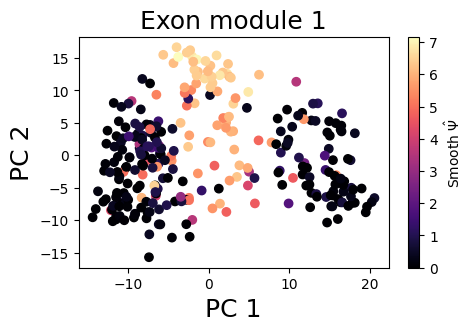

In [45]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=norm_expression.loc['Gad2', latent_p90.index], cmap='magma')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 1', fontsize=18)
plt.show()

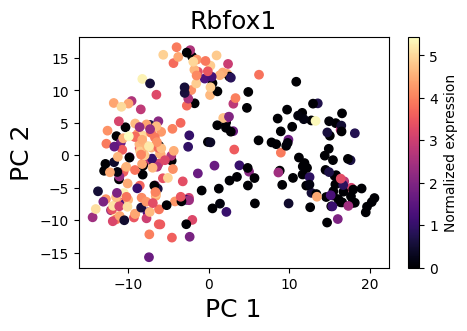

In [124]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=norm_expression.loc['Rbfox1', latent_p90.index], cmap='magma')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Rbfox1', fontsize=18)
plt.show()

In [88]:
from sklearn.cluster import AgglomerativeClustering as AC
ag = AC(3)
cell_types = ag.fit_predict(norm_expression.loc[['Nxph4', 'Th', 'Gad2'], latent_p90.index].T)
# cell_types = ag.fit_predict(norm_expression.loc[['Slc6a3', 'Nxph4', 'Aldh1a1', 'Th', 'Gad2'], latent_p90.index].T)

In [89]:
colores_p90 = []
for i in cell_types:
    if i == 0:
        colores_p90.append('tab:blue')
    elif i == 1:
        colores_p90.append('tab:green')
    elif i == 2:
        colores_p90.append('tab:red')
    elif i == 3:
        colores_p90.append('tab:purple')
    elif i == 4:
        colores_p90.append('tab:brown')
    elif i == 5:
        colores_p90.append('tab:pink')
    elif i == 6:
        colores_p90.append('tab:gray')
#     elif i == 8:
#         colores_p90.append('tab:cyan')

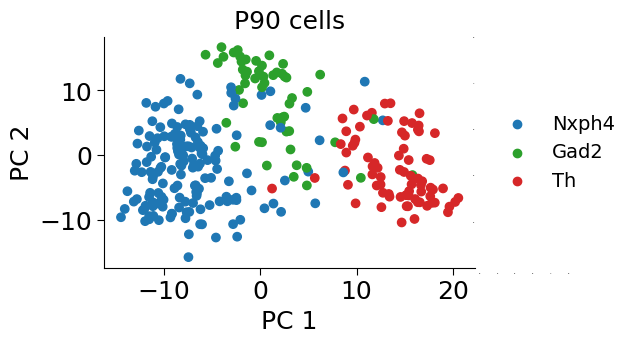

In [94]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore

fig = plt.figure(figsize=(6, 3))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=colores_p90)
ax.tick_params(labelsize=18, length=5)
ax.set_title('P90 cells', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='tab:blue', label='Nxph4')
ax_2.scatter([0], [0], c='tab:green', label='Gad2')
ax_2.scatter([0], [0], c='tab:red', label='Th')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

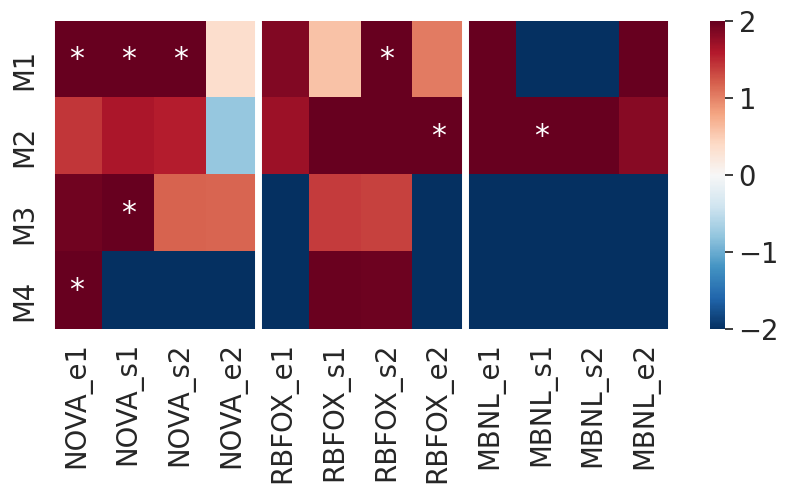

In [125]:
psix_results_p90 = pd.read_csv('psix_object_p90/psix_results.tab.gz', sep='\t', index_col=0)

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]



# mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results_p90.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [120]:
from scipy.stats import pearsonr, spearmanr
module_avg = pd.DataFrame()

for mod in range(1, 5):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi_p90.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi_p90.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Mbnl1', 'Mbnl2'])& norm_expression.index), len(module_avg.index))), 
                               index = (pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Mbnl1', 'Mbnl2'])& norm_expression.index), columns = module_avg.index)
for sf in tqdm(pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Mbnl1', 'Mbnl2'])& norm_expression.index):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod].fillna(module_avg.loc[mod].mean()),
                                                norm_expression.loc[sf, 
                                                                    module_avg.columns]
        )[0]

100%|██████████| 6/6 [00:00<00:00, 120.79it/s]


In [112]:
list(splicing_factors & norm_expression.index)

['Acin1',
 'Aqr',
 'Bcas2',
 'Bub3',
 'Bud13',
 'Bud31',
 'C1qbp',
 'Cd2bp2',
 'Cdc40',
 'Cdc5l',
 'Cdk12',
 'Celf1',
 'Celf2',
 'Celf3',
 'Celf4',
 'Celf5',
 'Cfap20',
 'Cirbp',
 'Clasrp',
 'Clk1',
 'Clk2',
 'Clk3',
 'Clk4',
 'Crnkl1',
 'Ctnnbl1',
 'Cwc15',
 'Cwc22',
 'Ddx17',
 'Ddx39',
 'Ddx39b',
 'Ddx3x',
 'Ddx3y',
 'Ddx41',
 'Ddx46',
 'Ddx5',
 'Dhx15',
 'Dhx16',
 'Dhx35',
 'Dhx38',
 'Dhx8',
 'Dhx9',
 'Dnajc8',
 'Eef1a1',
 'Eftud2',
 'Eif2s2',
 'Eif3a',
 'Eif4a3',
 'Elavl1',
 'Elavl2',
 'Elavl3',
 'Elavl4',
 'Fmr1',
 'Gm9833',
 'Grsf1',
 'Hnrnpa0',
 'Hnrnpa1',
 'Hnrnpa2b1',
 'Hnrnpc',
 'Hnrnpd',
 'Hnrnpf',
 'Hnrnph1',
 'Hnrnph2',
 'Hnrnph3',
 'Hnrnpk',
 'Hnrnpl',
 'Hnrnpll',
 'Hnrnpm',
 'Hnrnpr',
 'Hnrnpu',
 'Hnrnpul1',
 'Hspa1a',
 'Hspa5',
 'Hspa8',
 'Igf2bp3',
 'Ik',
 'Ilf2',
 'Ilf3',
 'Ints6',
 'Lsm1',
 'Lsm2',
 'Lsm3',
 'Lsm4',
 'Lsm5',
 'Lsm6',
 'Lsm7',
 'Lsm8',
 'Luc7l3',
 'Magoh',
 'Matr3',
 'Mfap1a',
 'Mfap1b',
 'Mov10',
 'Msi1',
 'Msi2',
 'Myef2',
 'Naa38',
 'Ncbp2',
 'Nelf

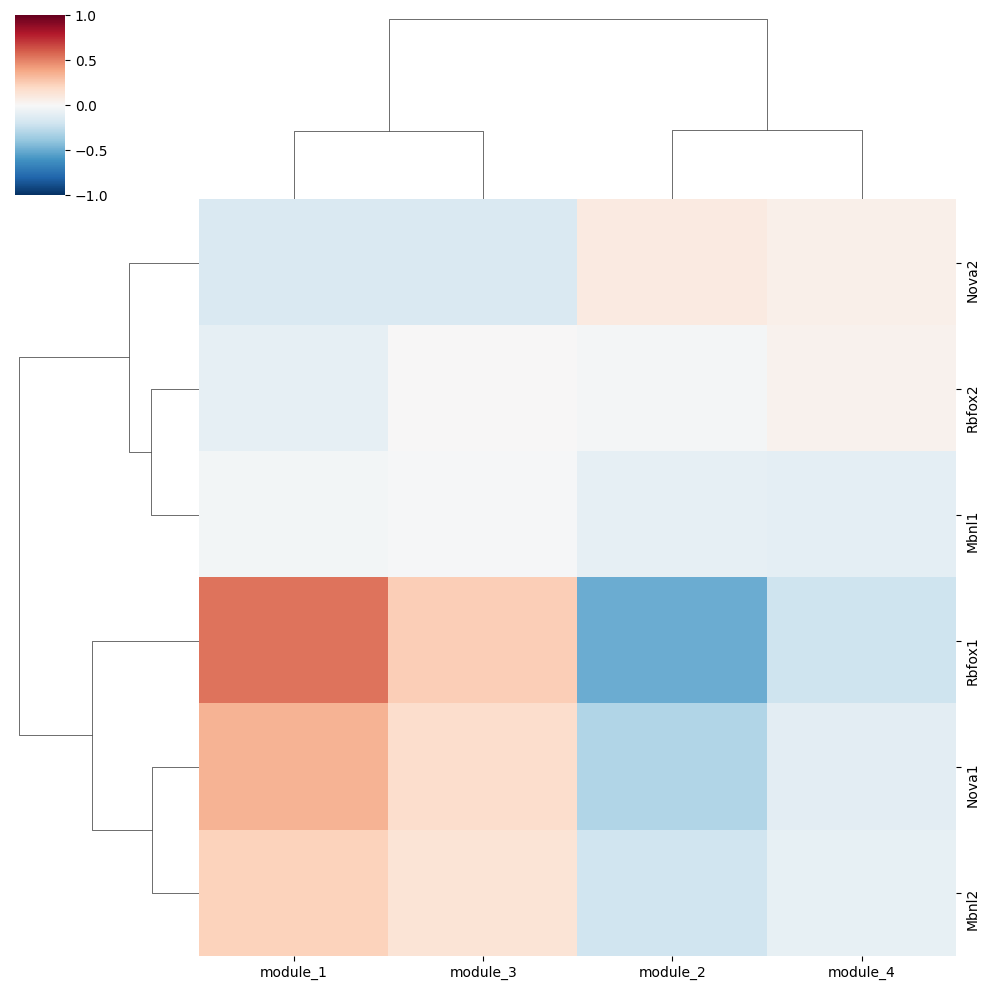

In [121]:
sns.clustermap(module_avg_corr, cmap='RdBu_r', vmin=-1, vmax=1)

In [101]:
splicing_factors & norm_expression.index

Index(['Acin1', 'Aqr', 'Bcas2', 'Bub3', 'Bud13', 'Bud31', 'C1qbp', 'Cd2bp2',
       'Cdc40', 'Cdc5l',
       ...
       'U2surp', 'Usp39', 'Usp39', 'Wbp11', 'Wtap', 'Xab2', 'Ybx1', 'Ybx3',
       'Zfp207', 'Zrsr2'],
      dtype='object', length=221)

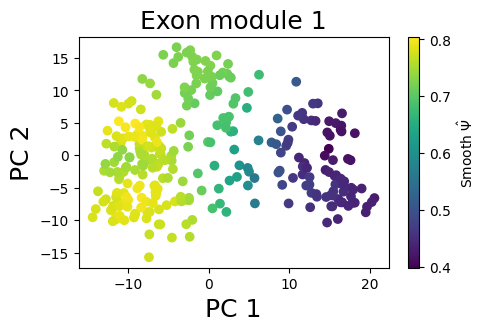

In [66]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=neighbors_psi_p90.loc[modules.loc[modules == 1].index, latent_p90.index].mean(axis=0), cmap='viridis')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 1', fontsize=18)
plt.show()

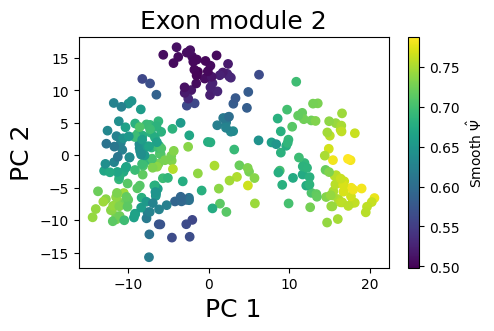

In [74]:
from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=neighbors_psi_p90.loc[modules.loc[modules == 4].index, latent_p90.index].mean(axis=0), cmap='viridis')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 2', fontsize=18)
plt.show()

In [147]:
from sklearn.preprocessing import StandardScaler
scaled_counts_p90 = pd.DataFrame(StandardScaler().fit_transform(norm_expression[latent_p90.index].T).T)
scaled_counts_p90.index = norm_expression.index
scaled_counts_p90.columns = latent_p90.index

hs_p90 = pd.read_csv('psix_object_p90/hotspot_p90.tab.gz', sep='\t', index_col=0)
hs_genes = hs_p90.index[hs_p90.FDR <= 0.01]
smooth_gene = get_background(scaled_counts_p90.loc[hs_genes], latent_p90, n_neighbors=30, remove_self=False).T



slicing exons...


100%|██████████| 1430/1430 [00:01<00:00, 1352.23it/s]


<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

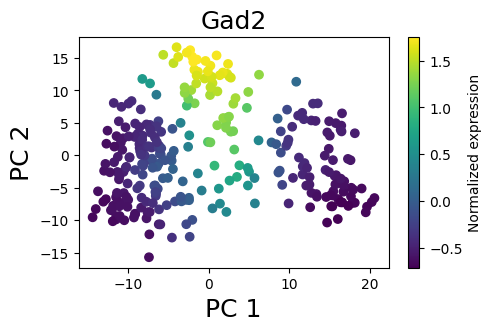

In [159]:
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc['Gad2', latent_p90.index], cmap='viridis')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Gad2', fontsize=18)
plt.show()

Text(0.5, 1.0, 'Nova1')

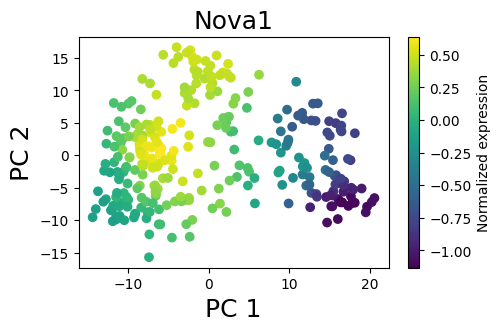

In [184]:
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc['Nova1', latent_p90.index], cmap='viridis')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Nova1', fontsize=18)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


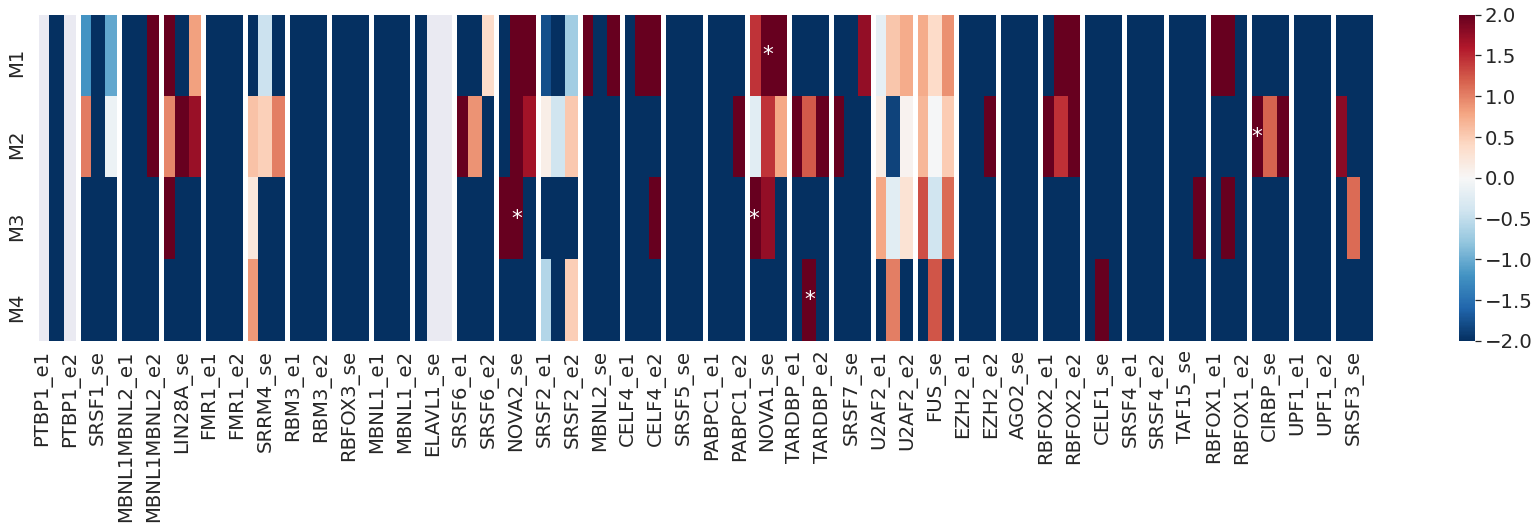

In [66]:
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab.gz', sep='\t', index_col=0)


mouse_clip_indiv = pd.DataFrame()
for rbp in mouse_clip_peaks.columns:
    mouse_clip_indiv[rbp+'_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, rbp])
    mouse_clip_indiv[rbp+'_se'] = np.array(mouse_clip_peaks.loc[se_exons, rbp])
    mouse_clip_indiv[rbp+'_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, rbp])
    
    mouse_clip_indiv.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]


    
mouse_clip_indiv = mouse_clip_indiv.loc[psix_results_p90.index & mouse_clip_indiv.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_indiv.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_indiv[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

Text(0.5, 1.0, 'Module 2 (Rbfox1)')

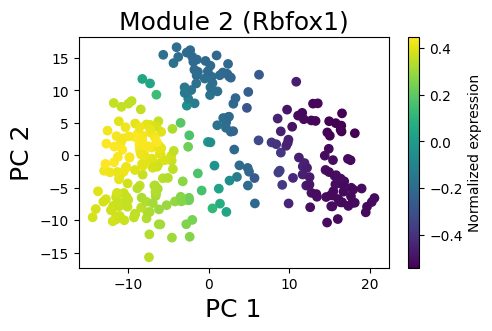

In [201]:
plt.figure(figsize=(5, 3))
modules_genes = pd.read_csv('psix_object/modules_genes_p90.tab.gz', sep='\t', index_col=0).Module

from scipy.stats import zscore
sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc[modules_genes.loc[modules_genes == 2].index, latent_p90.index].mean(axis=0))
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Module 2 (Rbfox1)', fontsize=18)

Text(0.5, 1.0, 'Module 5 (Nova1)')

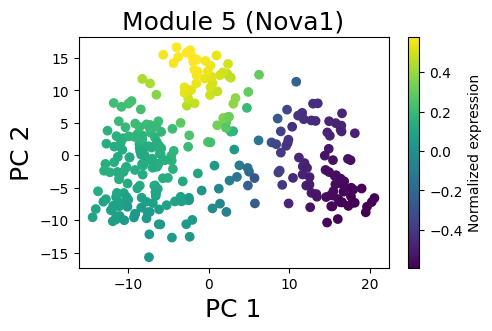

In [202]:
plt.figure(figsize=(5, 3))
modules_genes = pd.read_csv('psix_object/modules_genes_p90.tab.gz', sep='\t', index_col=0).Module

from scipy.stats import zscore
sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc[modules_genes.loc[modules_genes == 5].index, latent_p90.index].mean(axis=0))
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Module 5 (Nova1)', fontsize=18)

In [189]:
pd.Index([x.upper() for x in modules_genes.index[modules_genes == 5]]) & mouse_clip_peaks.columns

Index(['NOVA1'], dtype='object')

In [96]:
modules_genes.unique()

array([ 1,  2,  3, -1,  4,  5,  6])

In [200]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [208]:
modules.loc[[x for x in modules.index if 'nmdSE' in x]]

Bnip2_nmdSE_1      1
Rps6kb2_nmdSE_1    1
Stx3_nmdSE_1       1
Vezt_nmdSE_1       3
Spint2_nmdSE_1     1
Name: Module, dtype: int64

In [212]:
np.mean(['nmdSE' in x for x in psix_results_p90.index])

0.08416075650118203

In [214]:
np.mean(['nmdSE' in x for x in modules.index])

0.09259259259259259